In [0]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 9.6MB/s 
     |████████████████████████████████| 1.1MB 43.2MB/s 
     |████████████████████████████████| 890kB 48.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=356c7f63f72c564bb7cb1c0f85e3f6054f5a69a8e698b780915fbe5f20ee964e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from nltk.corpus import wordnet
import random
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Function Definitions

In [0]:
#Generator Function for Non-Numeric Words
#X is a pandas Series of a sentence
#here gamma is the number of iterations
#returns a series of modified messages (might be modified)
def generatorWords(X,gamma):
 
  fakeX = []
  
  if len(X.unique()) < len(X)/2: #if the number of unique values is less than half of the set
    uniqueVals = X.unique()
    fakeX = []
    for i in range(len(X)):
      fakeX.append(random.choice(uniqueVals))
  else:
    for index, value in X.items(): 
      words = value.split(" ")
      adjs = []
      choosenWord = ""
      pos_all = dict()
      antonyms = []

      #priortize adjectives
      for w in words:
        #print(w)
        pos_l = set()
        for tmp in wn.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.add(tmp.pos())
        pos_all[w] = pos_l

      #in the list of word classes we single out the adjectives
      for a in pos_all:  
        if "a" in pos_all[a]:
          adjs.append(a)
      
      #here we choose which word to flip
      if adjs: 
        choosenWord = adjs[0] if len(adjs) > 1 else adjs[0]
      else:
        choosenWord = words[0] if len(words) > 1 else words[0]

      #find antonyms of the choosen word
      for syn in wordnet.synsets(choosenWord):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
      if antonyms:
        new = [antonyms[gamma] if x==choosenWord else x for x in words]
      else:
        new = [x if x==choosenWord else x for x in words]
      fakeX.append(" ".join(new))
  return pd.Series(fakeX)


In [0]:
#Generator Function For Numeric Data Points
#X is a series of numbers
#gamma = 1.4
#intX = list(map(int, X)) #make sure X is an int
def generatorNum(X,gamma):
  xHat = np.mean(X)
  sx = np.std(X)
  randomUpper = (xHat) + (sx * gamma)
  randomLower = (xHat) - (sx * gamma)
  beta = []
  for i in range(int(len(X))):
      beta.append(random.randrange(int(randomLower),int(randomUpper)))
  beta = list(map(str, beta))
  #print(beta)
  return pd.Series(beta)

In [0]:
#Generator That Points Data Into The Right Generator
def generator(df,gamma):
  mDF = df.copy()
  mDF["temperature"] = generatorNum(df["temperature"],gamma)
  mDF["outlook"] = generatorWords(df["outlook"],0)
  mDF["wind"] = generatorWords(df["wind"],0)
  mDF["humidity"] = generatorNum(df["humidity"],gamma)
  fakeData = addLabel(makeSentence(mDF),1) #column 0 is sentences, column 1 is label
  realData = addLabel(makeSentence(df),0)  #Label 0 means data, label 1 means fake data
  return(pd.concat([fakeData,realData],axis=0),fakeData)

In [0]:
#Merges All DataFrame Columns Into A Single Sentence
#Returns a series of the merged DataFrame columns
def makeSentence(df):
  #df is a data frame
  df = df.copy().applymap(str)
  seriesA = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  return seriesA

In [0]:
#Adds a label columns to series for classification
#Returns dataframe of two columns, the series and the labels
def addLabel(series,label):
  #takes in a pandas series and a label
  #returns a dataframe
  labels = []
  [labels.append(label) for i in range(len(series))]
  labels = pd.Series(labels)
  return pd.concat([series,labels],axis=1)

In [0]:
#Discriminiator for deteremining whether data is malicious or not
#Returns new gamma, other parameters are for testing and graphing purposes
def discriminator(X, gamma, rho):
  #takes in dataframe in BERT format of sentence and label
  #returns a new gamme to generate data with
  score,indexes,fn,total = BERT(X)
  print("score: " + str(score))
  #if 0.35 < score < 0.55:
  ##  return None
  #else:
  return (score,gamma + rho,indexes,fn,total)

In [0]:
def BERT(df):
  #df is a dataframe containing sentences and labels
  #BERT returns a accruacy and indexes of false negatives

  #tokenize
  tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad
  attention_mask = np.where(padded != 0, 1, 0)                            #apply masks
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)                           #put masks through torch tensor

  #run through bert
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df[1]
  return(regression(features,labels))

In [0]:
#Takes BERT pretrained output and put's it through logistic regression
#Returns accuracy and indexes of false negatives
def regression(features,labels):
  train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
  #lr_clf = LogisticRegression(max_iter=500)
  #lr_clf.fit(train_features, train_labels)
  #return(lr_clf.score(test_features, test_labels))
  NeuralNetwork = MLPClassifier(solver='adam', activation="logistic", random_state=1,max_iter=5000)
  NeuralNetwork.fit(train_features, train_labels)
  y2 = NeuralNetwork.predict(test_features)
  y2 = pd.Series(NeuralNetwork.predict(test_features))
  #print(test_labels)
  i=0
  indexes = []
  for index, value in test_labels.items():
    if value == 1:
      if y2[i] == 0:
        indexes.append(index)
    i+=1
  #print(indexes)
  tn, fp, fn, tp = confusion_matrix(test_labels, y2).ravel()
  #fp = confusion_matrix(test_labels, y2)[0][1]
  total = len(test_labels)
  return (NeuralNetwork.score(test_features,test_labels),indexes,fn,total)

In [0]:
def indexToEntry(X,indexes):
  #finds list of indexes in X and returns a dataframe with the entries
  entries = []
  for i in indexes:
    entries.append(X.iloc[i])
  return(pd.DataFrame(entries))

In [0]:
def logisticRegression(train_features, test_features, train_labels, test_labels):
  lr_clf = LogisticRegression(max_iter=500)
  lr_clf.fit(train_features, train_labels)
  #print(lr_clf.score(test_features, test_labels))
  y_pred = lr_clf.predict(test_features)
  score = lr_clf.score(test_features, test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  return(fn,score)

In [0]:
def RandomForest(train_features, test_features, train_labels, test_labels):
  RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  RandForest.fit(train_features, train_labels)
  forest_pred = RandForest.predict(test_features)
  score = RandForest.score(test_features,test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, forest_pred).ravel()
  return(fn,score)


In [0]:
def KNN(train_features, test_features, train_labels, test_labels):
  #K Nearest Neighbor With Optimal Neighbor (1)
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(train_features,train_labels)
  score = knn.score(test_features, test_labels)
  y_pred = knn.predict(test_features)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  #print(confusion_matrix(test_labels, y_pred))
  #print(classification_report(y_test, y_pred))
  return(fn,score)

In [0]:
def MLP(train_features, test_features, train_labels, test_labels):
  NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  NeuralNetwork.fit(train_features, train_labels)
  nn_pred = NeuralNetwork.predict(test_features)
  score = NeuralNetwork.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, nn_pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, nn_pred).ravel()
  return(fn,score)

In [0]:
def SVM(train_features, test_features, train_labels, test_labels):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(train_features,train_labels)
  svmPred = clf.predict(test_features)
  score = clf.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, svmPred).ravel()
  return(fn,score)

In [0]:
def tests(df,mDF):
  ogData = addLabel(makeSentence(df),0)
  testData = pd.concat([ogData,mDF])
  tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)
  lrFN,lrScore = logisticRegression(train_features, test_features, train_labels, test_labels)
  rfFN,rfScore = RandomForest(train_features, test_features, train_labels, test_labels)
  knnFN,knnScore = KNN(train_features, test_features, train_labels, test_labels)
  mlpFN,mlpScore = MLP(train_features, test_features, train_labels, test_labels)
  svmFN,svmScore = SVM(train_features, test_features, train_labels, test_labels)
  #print("test_labels: " + str(len(test_labels)))
  return(lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore)

## Processing

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/HenryCWong/adversarialBERTMessages/master/weather_sample_data.csv', delimiter=',')

In [0]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [0]:
df.head()

,temperature,outlook,wind,humidity
0,40,cloudy,E,14
1,51,partly cloudy,SE,95
2,47,severe_thunderstorm,SE,88
3,45,thunderstorm,W,35
4,43,sunny,SE,33


## Actual Stuffs

In [0]:
X,mDF = generator(df,1)

In [0]:
mDF

,0,1
0,"54,severe_thunderstorm,S,45",1
1,"48,cloudy,NE,59",1
2,"49,thunderstorm,SE,46",1
3,"46,partly cloudy,NE,70",1
4,"44,rain,NW,25",1
...,...,...
495,"49,severe_thunderstorm,N,36",1
496,"45,thunderstorm,None,37",1
497,"43,cloudy,SW,38",1
498,"54,sunny,SW,20",1


In [0]:
tests(df,mDF) #logistic regression, random forest, knn, mlp, svm

(63, 0.484, 40, 0.6, 49, 0.556, 29, 0.528, 31, 0.564)

In [0]:
score,gamma,indexes,jp,total = discriminator(X,1,1)

score: 0.716


In [0]:
print(jp)
print(total)

22
250


In [0]:
malDF = indexToEntry(X,indexes)

In [0]:
malDF.head()

,0,1
277,"52,thunderstorm,SW,34",1
292,"47,cloudy,N,41",1
275,"48,sunny,NE,34",1
67,"53,cloudy,None,77",1
351,"45,rain,NE,76",1


In [0]:
gamma = 1
rho = .1
sets = []
scores = []
fns = []
totals = []
gammas = []
lrFNs = []
rfFNs = []
knnFNs = []
mlpFNs = []
svmFNs = []
lrScores = []
rfScores = []
knnScores = []
mlpScores = []
svmScores = []
j = 0
while j < 30:
  X,mDF = generator(df,gamma)
  #print(gamma)
  score,gamma, indexes,fn,total = discriminator(X,gamma,rho)
  scores.append((j,score))
  #malDF = pd.concat([malDF,indexToEntry(X,indexes)])
  lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore = tests(df,mDF)
  #lists for stats
  lrFNs.append(lrFN)
  rfFNs.append(rfFN)
  knnFNs.append(knnFN)
  mlpFNs.append(mlpFN)
  svmFNs.append(svmFN)
  lrScores.append(lrScore)
  rfScores.append(rfScore)
  knnScores.append(knnScore)
  mlpScores.append(mlpScore)
  svmScores.append(svmScore)
  sets.append(indexToEntry(X,indexes))
  fns.append(fn)
  totals.append(total)
  gammas.append(gamma)
  j+=1


score: 0.688
score: 0.68
score: 0.632
score: 0.62
score: 0.572
score: 0.588
score: 0.544
score: 0.524
score: 0.536
score: 0.568
score: 0.628
score: 0.548
score: 0.644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.612


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.624


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.692


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.708


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.696


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.716


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.764


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.744


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.708


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.748


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.712


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.788
score: 0.82
score: 0.804


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.828


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score: 0.848
score: 0.844


In [0]:
sortedScores = sorted(scores, key=lambda tup: tup[1])

In [0]:
index,score = sortedScores[0]
malDF = sets[index]
for i in range(1,7):
  index, score = sortedScores[i]
  malDF = pd.concat([malDF,sets[index]])

In [0]:
malDF

,0,1
411,"43,cloudy,W,26",1
136,"56,severe_thunderstorm,None,87",1
76,"45,partly cloudy,None,57",1
280,"40,partly cloudy,None,16",1
319,"43,thunderstorm,N,6",1
...,...,...
141,"55,sunny,SE,25",1
331,"51,thunderstorm,W,87",1
333,"58,severe_thunderstorm,N,45",1
306,"42,cloudy,NE,7",1


In [0]:
df["temperature"].std()

6.261462434898679

In [0]:
#malDF = pd.concat([malData,addLabel(makeSentence(df),0)])

## Graphing

In [0]:
print(gammas)
print(fns)
print(totals)
print(scores)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 1.6000000000000005, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001, 2.100000000000001, 2.200000000000001, 2.300000000000001, 2.4000000000000012, 2.5000000000000013, 2.6000000000000014, 2.7000000000000015, 2.8000000000000016, 2.9000000000000017, 3.0000000000000018, 3.100000000000002, 3.200000000000002, 3.300000000000002, 3.400000000000002, 3.500000000000002, 3.6000000000000023, 3.7000000000000024, 3.8000000000000025, 3.9000000000000026, 4.000000000000003]
[33, 22, 31, 24, 34, 27, 30, 88, 55, 55, 67, 67, 54, 38, 46, 42, 55, 53, 41, 40, 47, 43, 51, 63, 39, 24, 34, 27, 31, 24]
[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]
[(0, 0.688), (1, 0.68), (2, 0.632), (3, 0.62), (4, 0.572), (5, 0.588), (6, 0.544), (7, 0.524), (8, 0.536), (9, 0.568), (10, 0.628), (11, 0.548), (12, 0.

In [0]:
for a in scores:
  print(a[1])

0.688
0.68
0.632
0.62
0.572
0.588
0.544
0.524
0.536
0.568
0.628
0.548
0.644
0.612
0.624
0.692
0.708
0.696
0.716
0.764
0.744
0.708
0.748
0.712
0.788
0.82
0.804
0.828
0.848
0.844


In [0]:
numScores = []
[numScores.append(a[1]) for a in scores]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

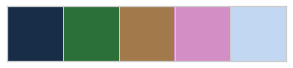

In [229]:
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("cubehelix", 5))
sns.set_palette("cubehelix",5)

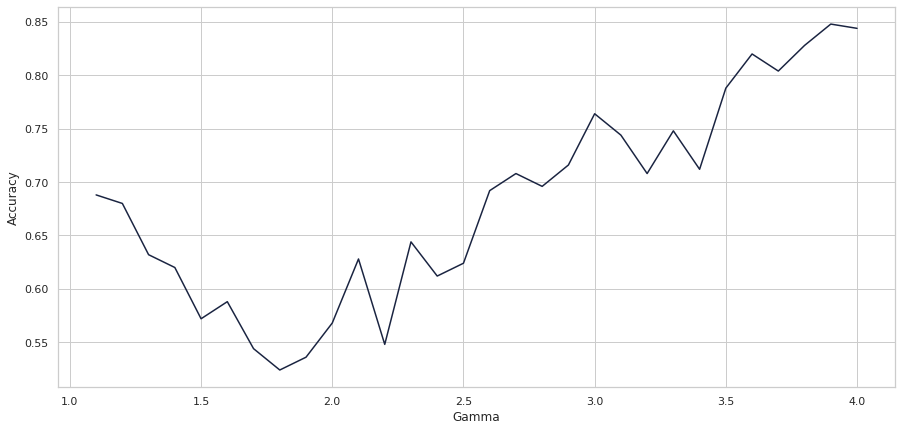

In [66]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='Accuracy')
sns.lineplot(ax=ax,x=gammas,y=numScores)
#ax = sns.lineplot(x=gammas, y=numScores)


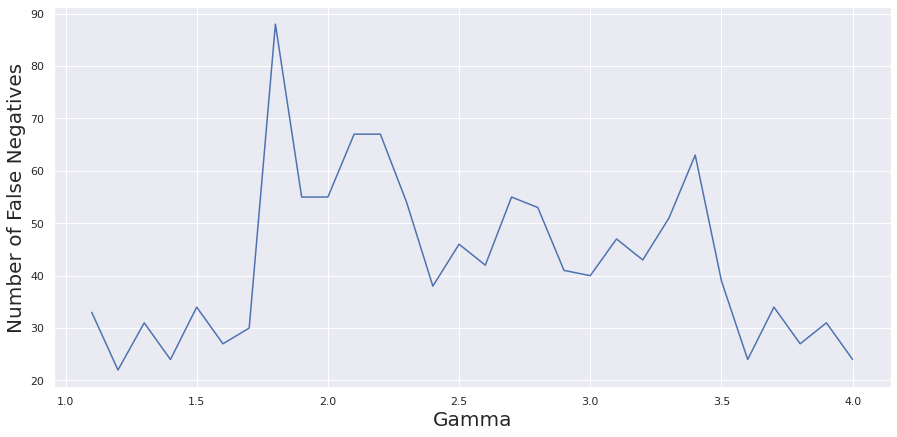

In [0]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
#ax.set(xlabel='Gamma', ylabel='False Positives')
sns.lineplot(ax=ax,x=gammas,y=fns,markers=True)
#ax = sns.lineplot(x=gammas, y=numScores)


In [0]:
fpRatio = []
for i in range(len(fns)):
  fpRatio.append(fns[i]/totals[i])

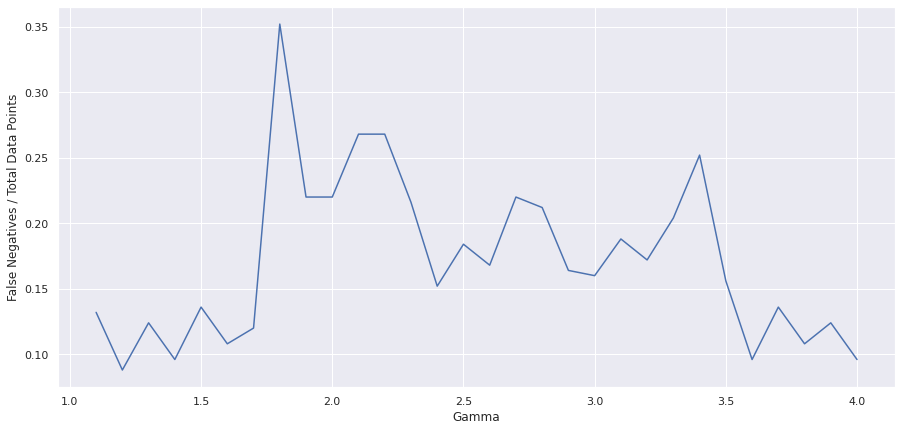

In [0]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='False Negatives / Total Data Points')
sns.lineplot(ax=ax,x=gammas,y=fpRatio)


In [0]:
d = {"gamma":gammas,"score":numScores,"fn":fns}
nDF = pd.DataFrame(data=d)

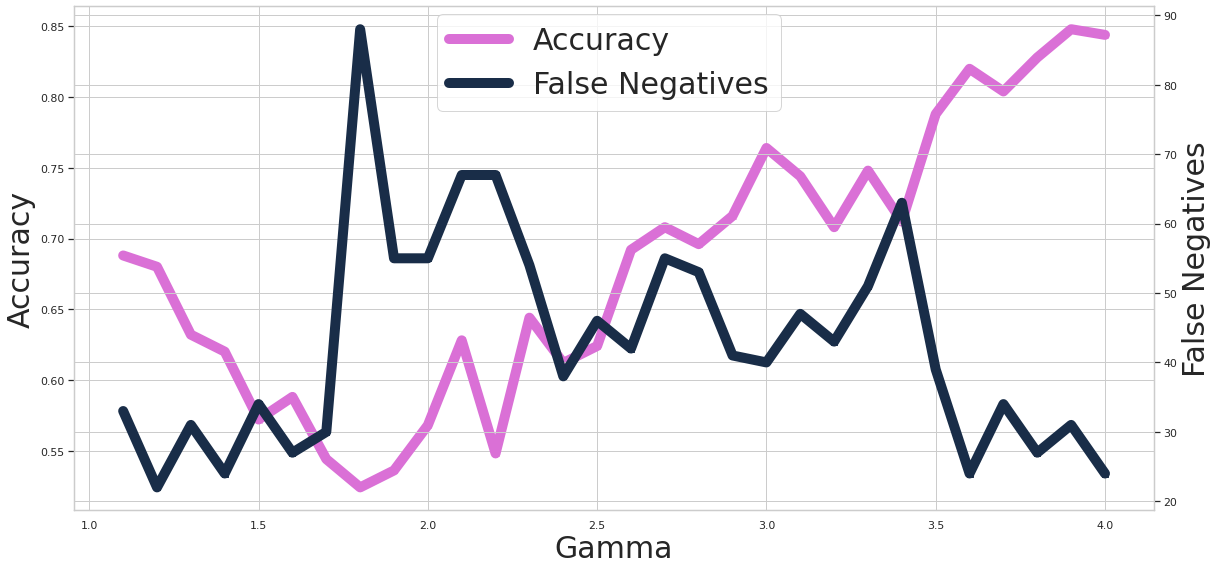

In [236]:
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(nDF["gamma"],nDF["score"],color="orchid",marker="x",linewidth=10.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(nDF["gamma"],nDF["fn"],marker="s",linewidth=10.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='upper center',prop={'size': 30})
plt.show()

In [0]:
#Iterpolation attempt
import scipy.interpolate 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


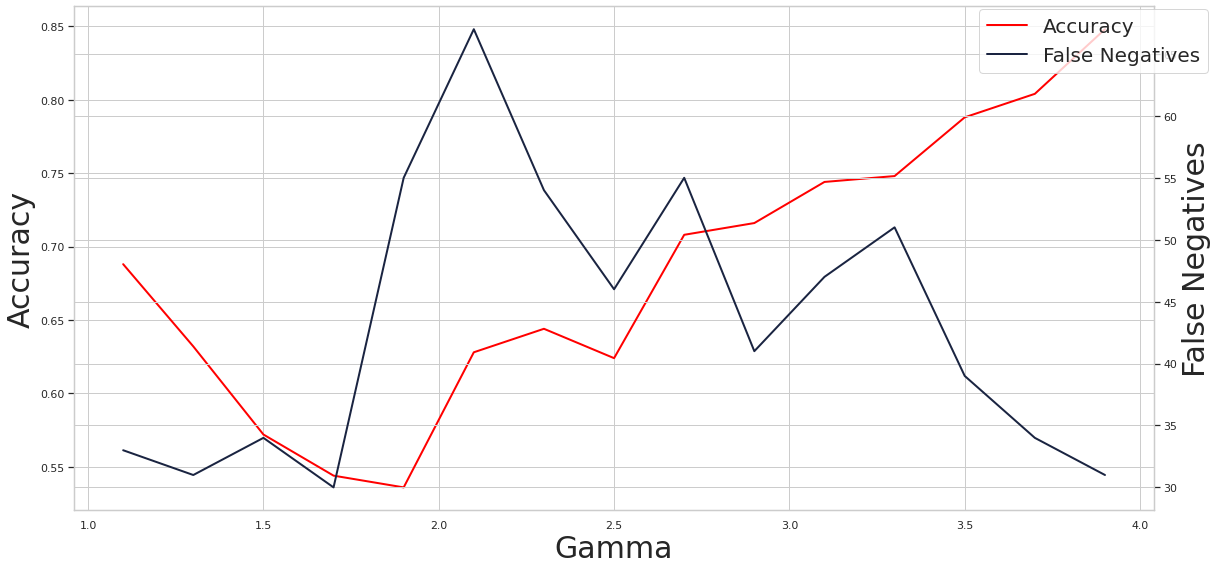

In [218]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')
xnew = np.arange(1.1,4,.2)
df2 = pd.DataFrame()
df2['score'] = f1(xnew)
df2['fn'] = f2(xnew)
df2["xnew"] = xnew
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(df2["xnew"],df2["score"],color="red",linewidth=2.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(df2["xnew"],df2["fn"],linewidth=2.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='best',prop={'size': 20})
plt.show()

In [0]:
x_new = np.linspace(1, 4, 300)
a_BSpline = interpolate.make_interp_spline(x, y)
y_new = a_BSpline(x_new)

   Weight_A
0     0.688
1     0.620
2     0.544
3     0.568
4     0.644
5     0.692
6     0.716
7     0.708
8     0.788
9     0.828


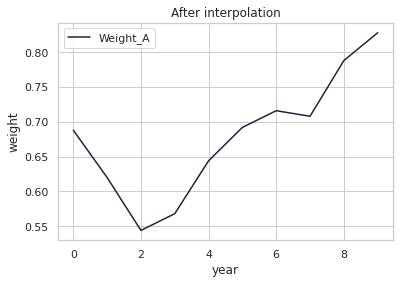

In [198]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')

xnew = np.arange(1.1,4,.3)
df2 = pd.DataFrame()
df2['Weight_A'] = f1(xnew)
#df2['Weight_B'] = f2(xnew)
print(df2)
ax2 = df2.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("year")
ax2.set_ylabel("weight")


plt.show()

In [0]:
d = {"Logistic Regression":lrFNs,"Random Forest":rfFNs,"K Nearest Neighbor":knnFNs,"Multi-Layer Perceptron":mlpFNs,"Support Vector Classification":svmFNs,"gamma":gammas}
#n = np.array([lrFNs,rfFNs,knnFNs,mlpFNs,svmFNs])
mlstuffs = pd.DataFrame(d)

In [0]:
print(svmScores)

[0.568, 0.608, 0.552, 0.516, 0.488, 0.428, 0.488, 0.54, 0.488, 0.464, 0.52, 0.544, 0.496, 0.556, 0.524, 0.58, 0.56, 0.564, 0.62, 0.716, 0.656, 0.688, 0.668, 0.7, 0.704, 0.752, 0.752, 0.76, 0.796, 0.756]


In [0]:
s = {"Logistic Regression":lrScores,"Random Forest":rfScores,"K Nearest Neighbor":knnScores,"Multi-Layer Perceptron":mlpScores,"Support Vector Classification":svmScores,"gamma":gammas}
scoreStuffs = pd.DataFrame(s)

In [0]:
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores.columns = ["gamma","Classification Model","Accuracy"]

In [0]:
meltedML = mlstuffs.melt(id_vars=['gamma'])
meltedML.columns = ["gamma","Classification Model","Number of False Negatives"]

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
meltedScores.to_csv('meltedScores.csv')
meltedML.to_csv("meltedML.csv")
!cp meltedScores.csv "drive/My Drive/Research"
!cp meltedML.csv "drive/My Drive/Research"

In [0]:
meltedML.head()

,gamma,Classification Model,Number of False Negatives
0,1.1,Logistic Regression,67
1,1.2,Logistic Regression,64
2,1.3,Logistic Regression,63
3,1.4,Logistic Regression,64
4,1.5,Logistic Regression,57


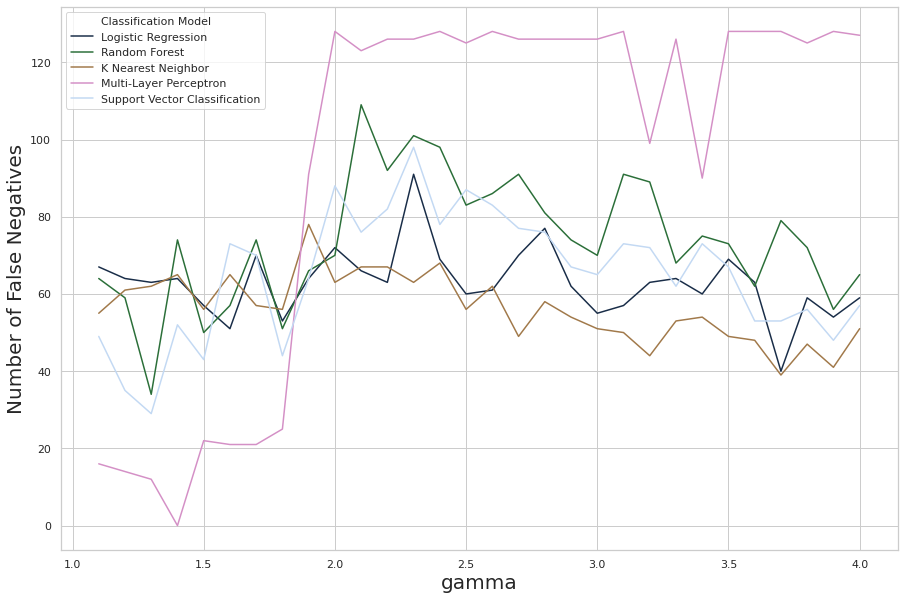

In [230]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Number of False Negatives",hue="Classification Model",data=meltedML)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

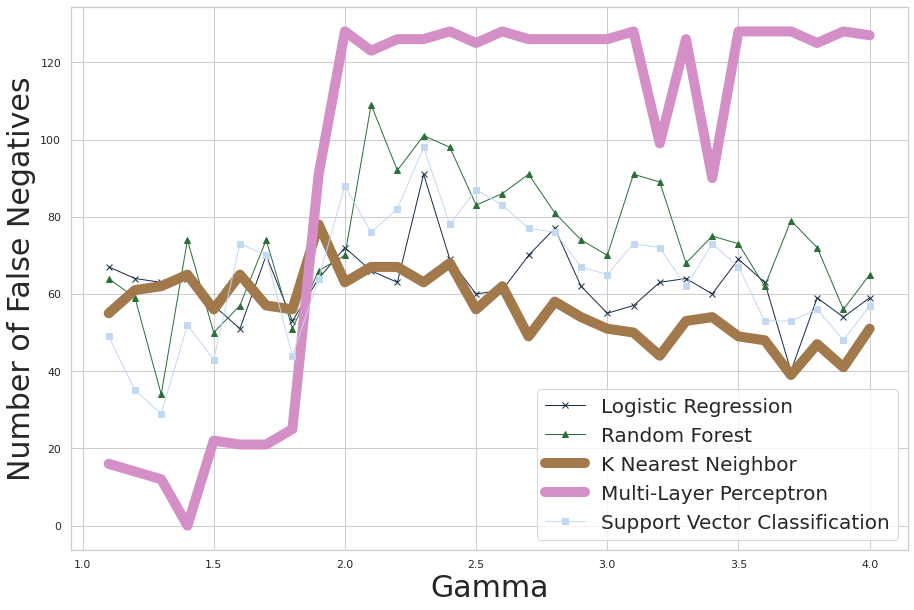

In [231]:
#plt.plot(meltedML[meltedML["Classification Model"] == "Logistic Regression"])
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Number of False Negatives',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedML[meltedML["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "K Nearest Neighbor":
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


In [0]:
meltedScores.head()

,gamma,Classification Model,Accuracy
0,1.1,Logistic Regression,0.484
1,1.2,Logistic Regression,0.512
2,1.3,Logistic Regression,0.484
3,1.4,Logistic Regression,0.496
4,1.5,Logistic Regression,0.492


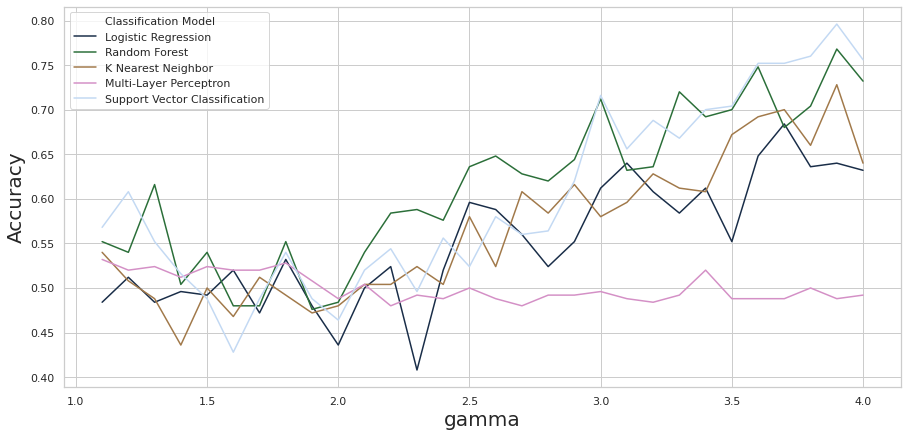

In [232]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Accuracy",hue="Classification Model",data=meltedScores)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

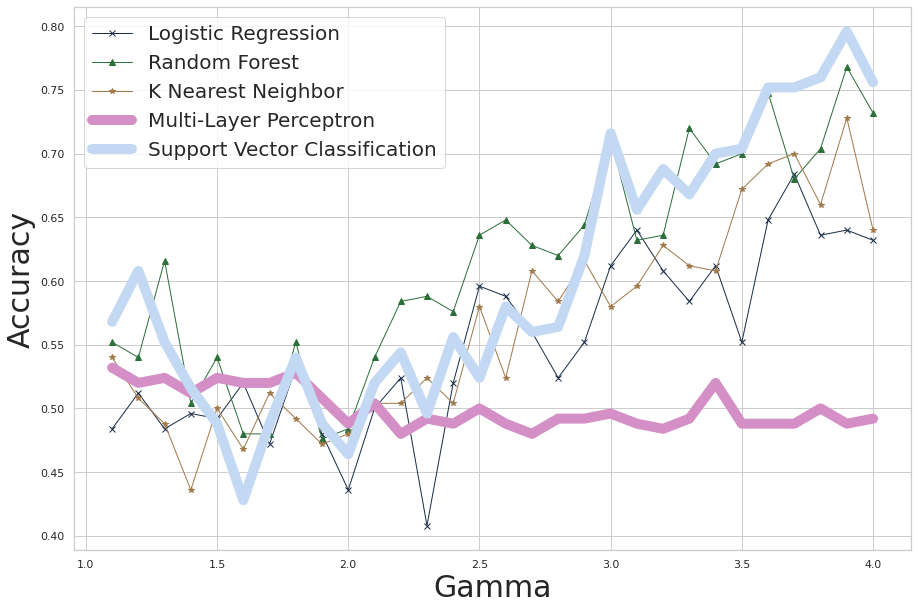

In [233]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Accuracy',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedScores[meltedScores["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "Support Vector Classification":
    plt.plot(a["gamma"],a["Accuracy"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Accuracy"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


# Attempted Test

In [0]:
ogData = addLabel(makeSentence(df),0)

In [0]:
testData = pd.concat([ogData,malDF])

In [0]:
testData

,0,1
0,"40,cloudy,E,14",0
1,"51,partly cloudy,SE,95",0
2,"47,severe_thunderstorm,SE,88",0
3,"45,thunderstorm,W,35",0
4,"43,sunny,SE,33",0
...,...,...
249,"46,rain,SW,12",1
350,"50,cloudy,NW,70",1
192,"50,rain,SW,40",1
306,"56,thunderstorm,NW,77",1


In [0]:
testData[testData[1] == 1]

,0,1
411,"57,thunderstorm,NE,65",1
136,"41,sunny,SW,74",1
76,"45,rain,NW,86",1
280,"45,severe_thunderstorm,E,60",1
319,"51,cloudy,N,20",1
...,...,...
249,"46,rain,SW,12",1
350,"50,cloudy,NW,70",1
192,"50,rain,SW,40",1
306,"56,thunderstorm,NW,77",1


In [0]:
tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [0]:
padded

array([[ 101, 2871, 1010, ...,    0,    0,    0],
       [ 101, 4868, 1010, ...,  102,    0,    0],
       [ 101, 4700, 1010, ..., 1010, 6070,  102],
       ...,
       [ 101, 2753, 1010, ...,    0,    0,    0],
       [ 101, 5179, 1010, ...,  102,    0,    0],
       [ 101, 2753, 1010, ..., 1010, 3515,  102]])

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)

In [0]:
test_labels.value_counts()

0    124
1     90
Name: 1, dtype: int64

### Logistic Regression Test

In [0]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))
y_pred = lr_clf.predict(test_features)

0.5794392523364486


In [0]:
confusion_matrix(test_labels, y_pred)

array([[115,   9],
       [ 81,   9]])

### Random Forest Test

In [0]:
RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RandForest.fit(train_features, train_labels)
forest_pred = RandForest.predict(test_features)
print(RandForest.score(test_features,test_labels))

0.5747663551401869


In [0]:
confusion_matrix(test_labels, forest_pred)

array([[122,   2],
       [ 89,   1]])

### KNN

Accuracy 0.4953271028037383
[[73 51]
 [57 33]]


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

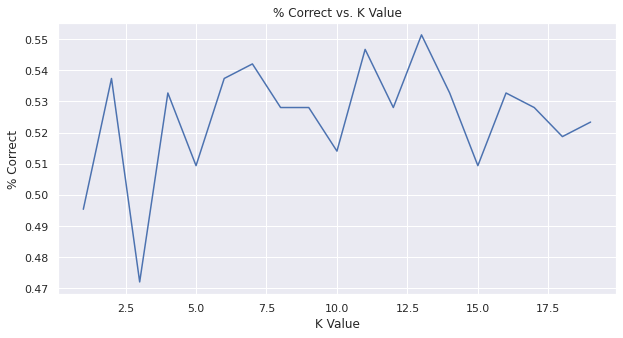

In [0]:
correct = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features,train_labels)
    prediction = knn.predict(test_features)
    correct.append(np.mean(prediction == test_labels))

    plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), correct)
plt.title('% Correct vs. K Value')
plt.xlabel('K Value')
plt.ylabel('% Correct')


#K Nearest Neighbor With Optimal Neighbor (1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_features,train_labels)
print("Accuracy " + str(knn.score(test_features, test_labels)))
y_pred = knn.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
#print(classification_report(y_test, y_pred))

### Neural Networks

In [0]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NeuralNetwork.fit(train_features, train_labels)
nn_pred = NeuralNetwork.predict(test_features)
print(NeuralNetwork.score(test_features,test_labels))
print(confusion_matrix(test_labels, nn_pred))

0.4392523364485981
[[ 16 108]
 [ 12  78]]


### SVM

In [0]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_features,train_labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [0]:
pred = clf.predict(test_features)

In [0]:
print(confusion_matrix(test_labels, pred))

[[124   0]
 [ 90   0]]


### OCSVM